In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
import numpy as np
import calendar

df = pd.read_csv('data/alarms.csv', sep=';')

num_ticks = 6

In [40]:
def format_duration(duration):
    delta = datetime.timedelta(seconds=duration)
    days = delta.days
    hours, remainder = divmod(delta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    parts = []
    if days:
        parts.append(f"{days} day{'s' if days != 1 else ''}")
    if hours:
        parts.append(f"{hours} hour{'s' if hours != 1 else ''}")
    if minutes:
        parts.append(f"{minutes} minute{'s' if minutes != 1 else ''}")
    if seconds:
        parts.append(f"{seconds} second{'s' if seconds != 1 else ''}")
    if not parts:
        parts.append("0 seconds")
    return ", ".join(parts)

def str_to_date(str):
    return datetime.datetime.strptime(str, "%Y-%m-%d %H:%M:%S")

def get_duration(prefix = ''):
    def duration(row):
        start = row['start']
        end = row[f'{prefix}end']
        if isinstance(start, str) and isinstance(end, str):
            dur = str_to_date(end) - str_to_date(start)
            return dur.total_seconds()
        return float('NaN')
    return duration


df['duration'] = df.apply(get_duration(), axis=1)
df['clean_duration'] = df.apply(get_duration('clean_'), axis=1)
df

,id,region_id,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id,duration,clean_duration
0,2,3,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,2771.0,2771.0
1,4,12,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,2951.0,2951.0
2,5,14,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,1805.0,1805.0
3,6,6,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,5442.0,5442.0
4,7,3,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NaN,7382.0,7382.0
...,...,...,...,...,...,...,...,...,...,...,...
19928,47472,5,️Донеччина,Донецька обл.,1,2023-01-20 22:39:41,2023-01-20 23:18:12,2023-01-20 23:18:12,NaN,2311.0,2311.0
19929,47532,19,Харківщина,Харківська обл.,1,2023-01-20 22:39:52,2023-01-20 23:17:36,2023-01-20 23:17:36,NaN,2264.0,2264.0
19930,47513,15,Полтавщина,Полтавська обл.,1,2023-01-20 22:44:30,2023-01-20 23:17:22,2023-01-20 23:17:22,NaN,1972.0,1972.0
19931,47520,17,Сумщина,Сумська обл.,1,2023-01-20 22:47:57,2023-01-20 23:22:34,2023-01-20 23:22:34,NaN,2077.0,2077.0


/var/folders/83/llmn6njx1sq55sdk04gmsv0r0000gn/T/ipykernel_56739/2836385996.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(i * interval / 86000)}d' for i in range(num_ticks)])


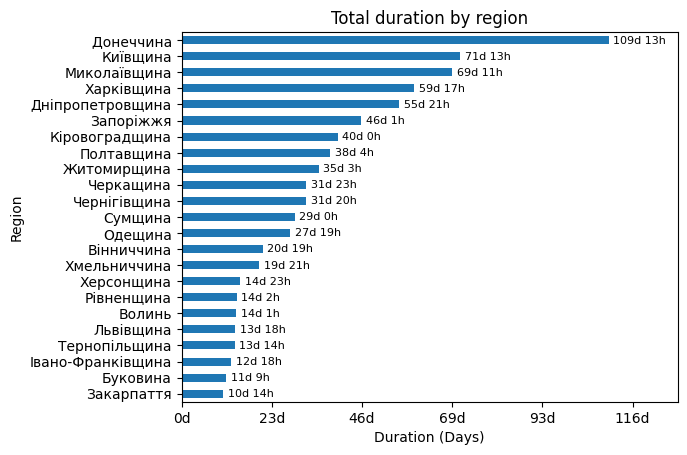

In [72]:
def total_by_city():
    duration_by_city = df.groupby('region_title')['duration'].sum().sort_values()
    ax = duration_by_city.plot(kind='barh', x='region_title', y='duration', rot=0)
    ax.set_xlabel('Duration (Days)')
    ax.set_xlim([0, 11_000_000])
    
    interval = 12_000_000 / num_ticks
    ax.set_xticklabels([f'{int(i * interval / 86000)}d' for i in range(num_ticks)])

    ax.set_ylabel('Region')
    ax.set_title('Total duration by region')

    for i, v in enumerate(duration_by_city):
        days, seconds = divmod(v, 86400)
        hours, seconds = divmod(seconds, 3600)
        ax.text(v + 105000, i - 0.2, f'{int(days)}d {int(hours)}h', color='black', fontsize=8)

    plt.show()

total_by_city()


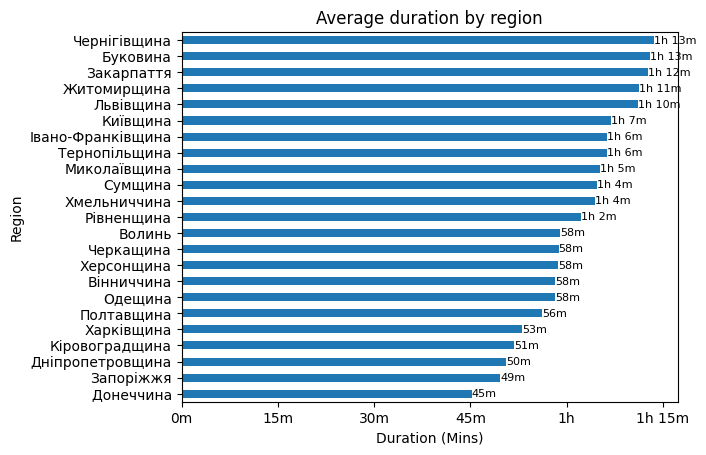

In [73]:
def average_by_city():
    def duration_to_hours(duration):
        return int(duration) / 3600.0

    average_duration_by_city = df.groupby('region_title')['duration'].mean().apply(duration_to_hours).sort_values()

    ax = average_duration_by_city.plot(kind='barh', x='region_title', y='duration', rot=0)
    ax.set_xlabel('Duration (Mins)')

    ax.set_ylabel('Region')
    ax.set_title('Average duration by region')


    def custom_tick_formatter(x, pos):
        hours = int(x)
        if hours >= 1:
            mins = int(round(x - 1.0, 2) * 60)

            if mins > 0:
                return f'{hours}h {mins}m'
            else:
                return f'{hours}h'
        else:
            mins = int(round(x, 2) * 60)
            return f'{mins}m'

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_tick_formatter))


    for i, v in enumerate(average_duration_by_city):
        hours = int(v)
        if hours >= 1:
            mins = int(round(v - 1.0, 2) * 60)
            ax.text(v, i - 0.2, f'{hours}h {mins}m', color='black', fontsize=8)
        else:
            mins = int(round(v, 2) * 60)
            ax.text(v, i - 0.2, f'{mins}m', color='black', fontsize=8)  

    plt.show()

average_by_city()



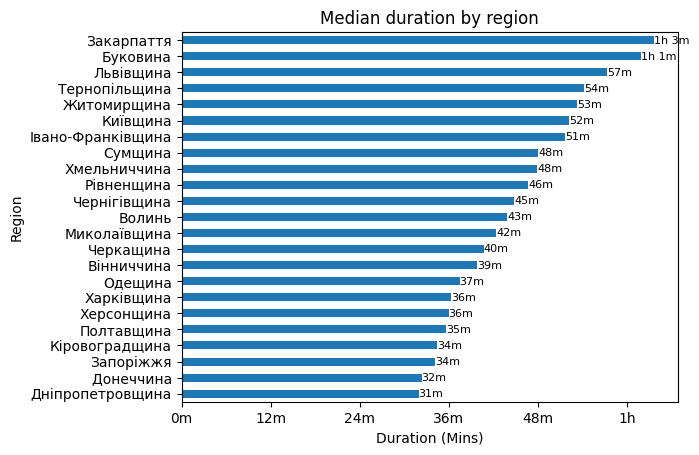

In [74]:
def median_by_city():
    def duration_to_hours(duration):
        return int(duration) / 3600.0

    average_duration_by_city = df.groupby('region_title')['duration'].median().apply(duration_to_hours).sort_values()

    ax = average_duration_by_city.plot(kind='barh', x='region_title', y='duration', rot=0)
    ax.set_xlabel('Duration (Mins)')

    ax.set_ylabel('Region')
    ax.set_title('Median duration by region')


    def custom_tick_formatter(x, pos):
        hours = int(x)
        if hours >= 1:
            mins = int(round(x - 1.0, 2) * 60)

            if mins > 0:
                return f'{hours}h {mins}m'
            else:
                return f'{hours}h'
        else:
            mins = int(round(x, 2) * 60)
            return f'{mins}m'

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_tick_formatter))


    for i, v in enumerate(average_duration_by_city):
        hours = int(v)
        if hours >= 1:
            mins = int(round(v - 1.0, 2) * 60)
            ax.text(v, i - 0.2, f'{hours}h {mins}m', color='black', fontsize=8)
        else:
            mins = int(round(v, 2) * 60)
            ax.text(v, i - 0.2, f'{mins}m', color='black', fontsize=8)  

    plt.show()

median_by_city()



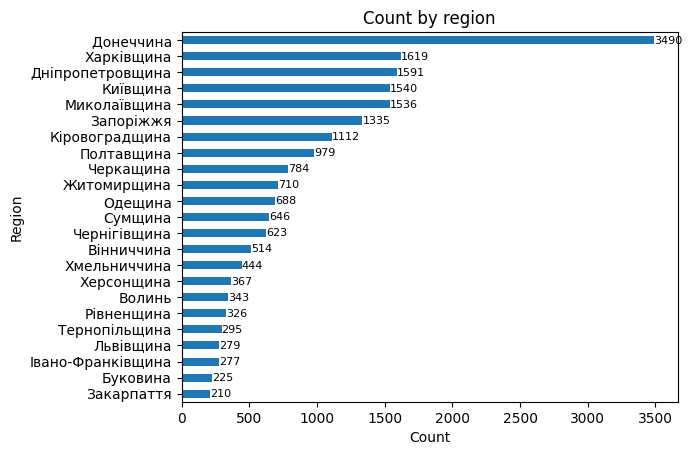

In [75]:
def count_by_city():
    average_duration_by_city = df['region_title'].value_counts().sort_values()

    ax = average_duration_by_city.plot(kind='barh', x='region_title', y='duration', rot=0)
    ax.set_xlabel('Count')

    ax.set_ylabel('Region')
    ax.set_title('Count by region')

    for i, v in enumerate(average_duration_by_city):
        ax.text(v, i - 0.2, f'{v}', color='black', fontsize=8)

    plt.show()

count_by_city()



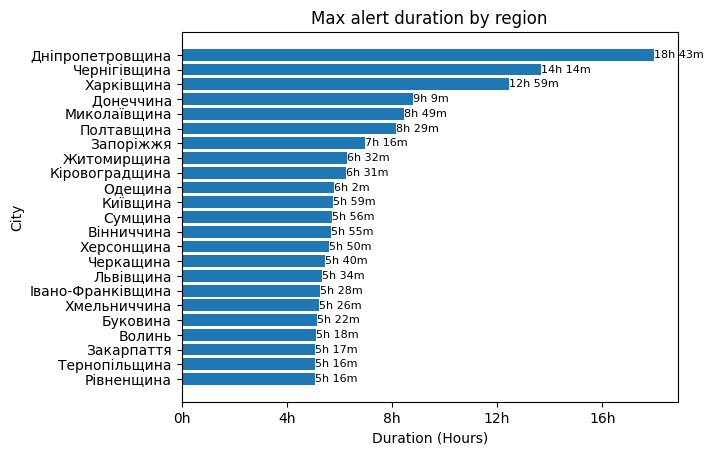

In [76]:
def max_by_city():
    max_df = df.groupby('region_title')['duration'].max().sort_values()

    fig, ax = plt.subplots()
    ax.barh(max_df.index, max_df)

    ax.set_ylabel('City')
    ax.set_xlabel('Duration (Hours)')

    ax.set_title('Max alert duration by region')

    def custom_tick_formatter(x, pos):
        hours, seconds = divmod(x, 3600)
        return f'{int(hours)}h'

    # Apply the custom tick formatter to the x-axis ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=7))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_tick_formatter))


    for i, v in enumerate(max_df):
        hours, seconds = divmod(v, 3600)
        minutes, seconds = divmod(seconds, 60)
        ax.text(v, i - 0.2, f'{int(hours)}h {int(minutes)}m', color='black', fontsize=8)

    plt.show()

max_by_city()



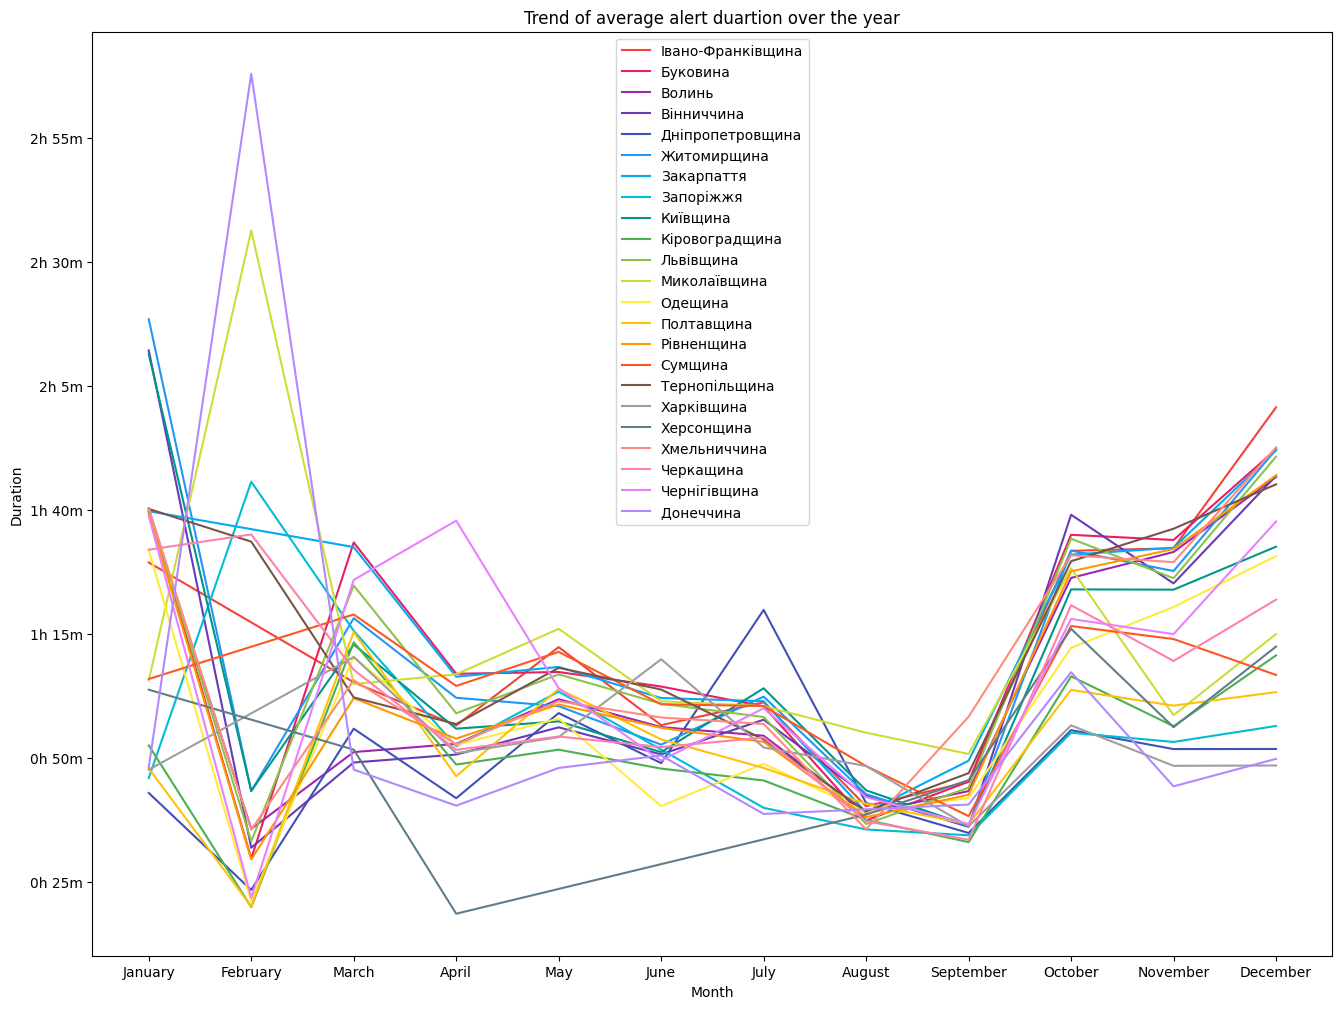

In [77]:

def mean_temp():
    df['start'] = pd.to_datetime(df['start'])
    fig, ax = plt.subplots(figsize=(16, 12))

    grouped_data = df.groupby(['region_title', df['start'].dt.month])['duration'].mean()
    grouped_data = grouped_data.reset_index()
    cities = grouped_data['region_title'].unique()

    ax.set_title('Trend of average alert duartion over the year')

    colors = ['#F44336', '#E91E63', '#9C27B0', '#673AB7', '#3F51B5', '#2196F3', '#03A9F4', '#00BCD4', '#009688', '#4CAF50', '#8BC34A', '#CDDC39', '#FFEB3B', '#FFC107', '#FF9800', '#FF5722', '#795548', '#9E9E9E', '#607D8B', '#FF8A80', '#FF80AB', '#EA80FC', '#B388FF', '#82B1FF']
    i = 0
    for city in cities:
        city_data = grouped_data[grouped_data['region_title'] == city]
        plt.plot(city_data['start'], city_data['duration'], label=city, color=colors[i])
        i = i + 1

    def custom_tick_formatter(x, pos):
        hours, seconds = divmod(x, 3600)
        minutes, seconds = divmod(seconds, 60)
        return f'{int(hours)}h {int(minutes)}m'

    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_tick_formatter))

    month_names = [calendar.month_name[i] for i in range(1, 13)]
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    plt.xticks(x, month_names)

    plt.xlabel('Month')
    plt.ylabel('Duration')
    plt.legend()
    plt.show()

mean_temp()


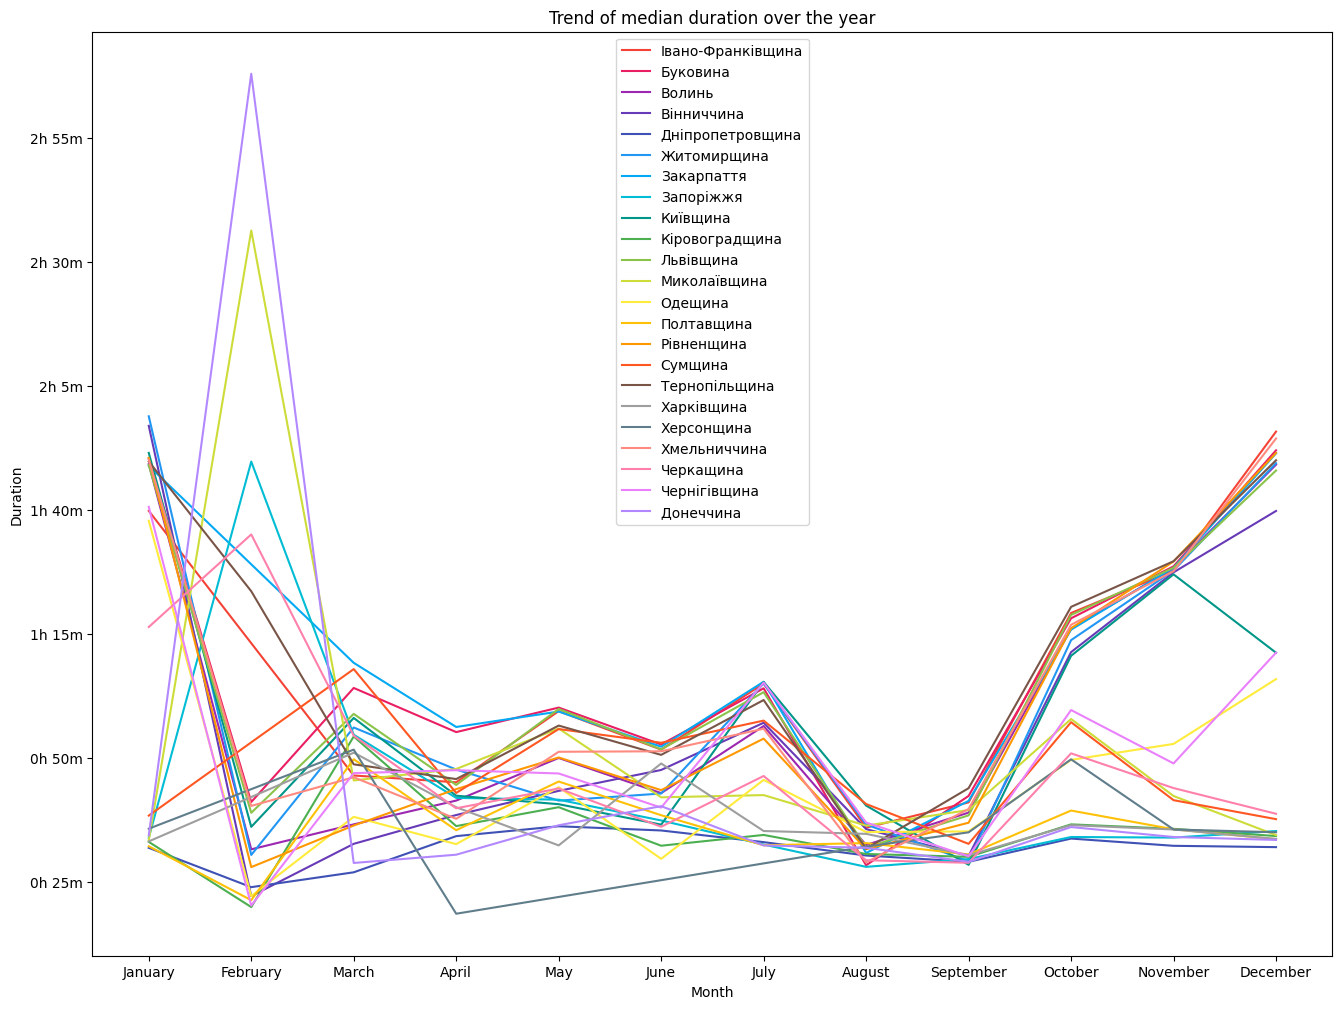

In [78]:

def median_temp():
    df['start'] = pd.to_datetime(df['start'])
    fig, ax = plt.subplots(figsize=(16, 12))
    
    grouped_data = df.groupby(['region_title', df['start'].dt.month])['duration'].median()
    grouped_data = grouped_data.reset_index()
    cities = grouped_data['region_title'].unique()

    ax.set_title('Trend of median duration over the year')

    colors = ['#F44336', '#E91E63', '#9C27B0', '#673AB7', '#3F51B5', '#2196F3', '#03A9F4', '#00BCD4', '#009688', '#4CAF50', '#8BC34A', '#CDDC39', '#FFEB3B', '#FFC107', '#FF9800', '#FF5722', '#795548', '#9E9E9E', '#607D8B', '#FF8A80', '#FF80AB', '#EA80FC', '#B388FF', '#82B1FF']
    i = 0
    for city in cities:
        city_data = grouped_data[grouped_data['region_title'] == city]
        plt.plot(city_data['start'], city_data['duration'], label=city, color=colors[i])
        i = i + 1

    def custom_tick_formatter(x, pos):
        hours, seconds = divmod(x, 3600)
        minutes, seconds = divmod(seconds, 60)
        return f'{int(hours)}h {int(minutes)}m'

    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_tick_formatter))

    month_names = [calendar.month_name[i] for i in range(1, 13)]
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    plt.xticks(x, month_names)

    plt.xlabel('Month')
    plt.ylabel('Duration')
    plt.legend()
    plt.show()



median_temp()


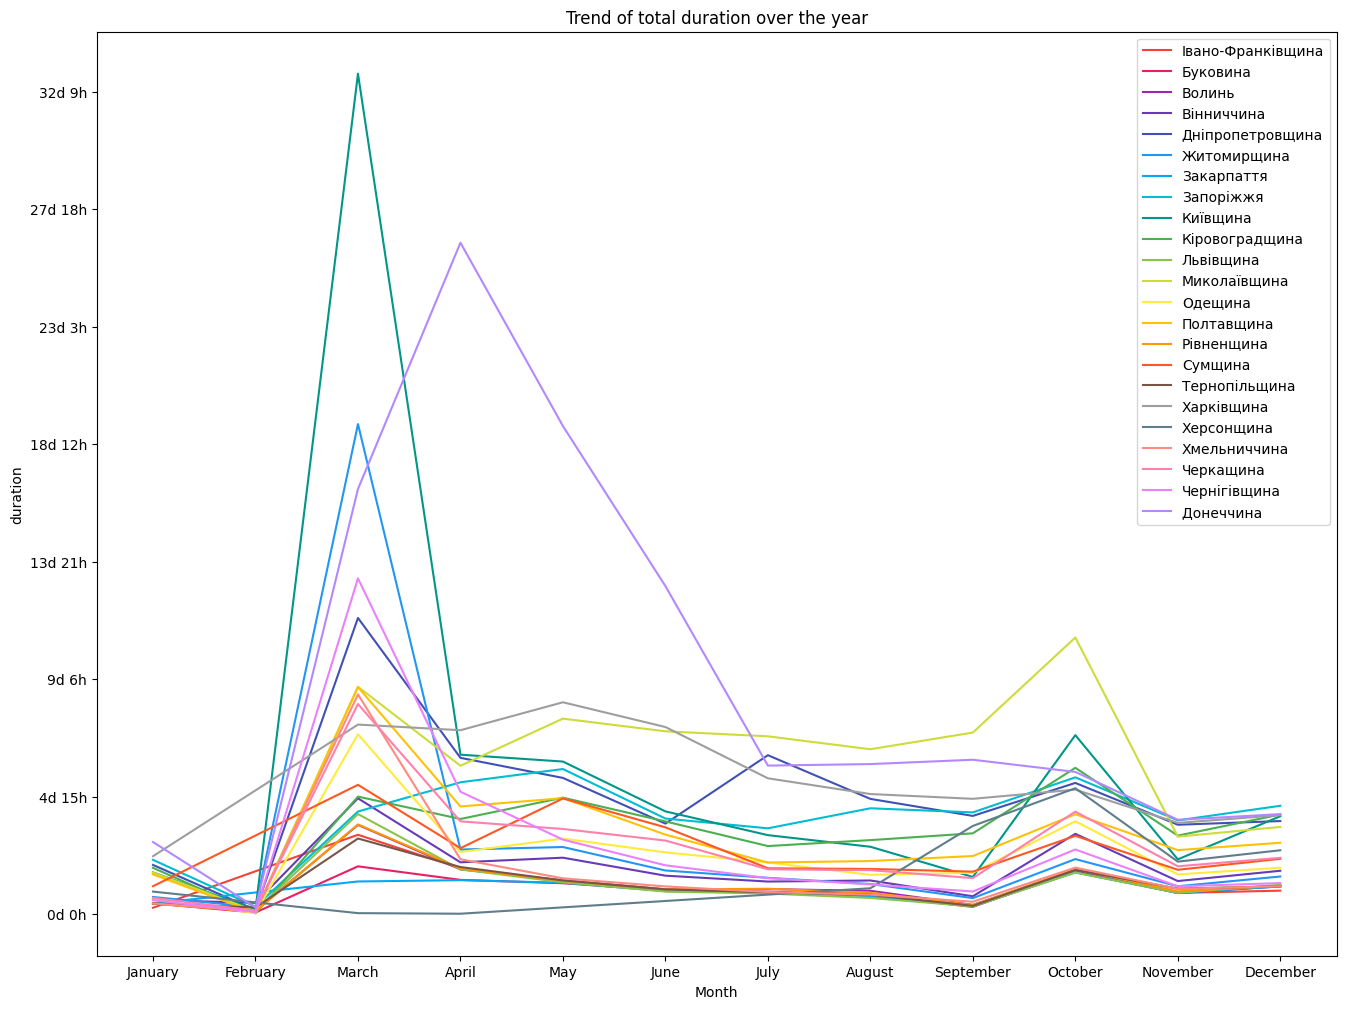

In [79]:

def mean_temp():
    df['start'] = pd.to_datetime(df['start'])
    fig, ax = plt.subplots(figsize=(16, 12))
    grouped_data = df.groupby(['region_title', df['start'].dt.month])['duration'].sum()

    grouped_data = grouped_data.reset_index()
    cities = grouped_data['region_title'].unique()


    ax.set_title('Trend of total duration over the year')

    colors = ['#F44336', '#E91E63', '#9C27B0', '#673AB7', '#3F51B5', '#2196F3', '#03A9F4', '#00BCD4', '#009688', '#4CAF50', '#8BC34A', '#CDDC39', '#FFEB3B', '#FFC107', '#FF9800', '#FF5722', '#795548', '#9E9E9E', '#607D8B', '#FF8A80', '#FF80AB', '#EA80FC', '#B388FF', '#82B1FF']
    i = 0
    for city in cities:
        city_data = grouped_data[grouped_data['region_title'] == city]
        plt.plot(city_data['start'], city_data['duration'], label=city, color=colors[i])
        i = i + 1

    def custom_tick_formatter(x, pos):
        days, seconds = divmod(x, 86400)
        hours, seconds = divmod(seconds, 3600)
        return f'{int(days)}d {int(hours)}h'

    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_tick_formatter))

    month_names = [calendar.month_name[i] for i in range(1, 13)]
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    plt.xticks(x, month_names)

    plt.xlabel('Month')
    plt.ylabel('duration')
    plt.legend()
    plt.show()

mean_temp()
